In [2]:
# debug总结：出现问题大部分可能是新版本的一些库使用方法已经过时，需要用新的方式来解决
# 很多时候是数据的维度问题，需要注意数据的维度，注意传入的数据是什么

import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rl_utils


# 定义策略网络（Policy Network），用于生成动作的概率分布
class PolicyNet(nn.Module):

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # 通过第二层并应用Softmax激活函数，得到动作概率分布


class ValueNet(nn.Module):

    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class PPO:
    '''PPO算法采用截断方式'''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用于训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = np.array(state,dtype=np.float32)
        if state.shape != (4,):
            print("State",state)
            raise ValueError(f"Expected state shape (4,), got {state.shape}")
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)  # 用于描述在给定概率分布下，从多个可能的结果中选择一个结果的概率。
        action = action_dist.sample()  # 作是根据概率分布 probs 随机选择的，概率越高的动作被选中的可能性越大。
        return action.item()  # item()把单个元素的torch元素转为标准python数

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)

        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)

        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):  # 这里的 _ 表示我们不关心 range(self.epochs) 生成的迭代值，我们只是想重复执行代码块 self.epochs 次。
            # self.epochs 很可能是一个整数，表示训练过程中的迭代次数或周期数。
            #如果我们将 _ 替换为其他变量名，代码的行为不会有任何改变，但是代码的可读性可能会降低，因为使用 _ 明确表示我们不关心迭代的具体值
            # for i in range(self.epochs):

            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断

            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


In [4]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 100 # 专家模型训练的轮数
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
state, info = env.reset(seed=0)
# print(state)
state = np.array(state, dtype=np.float32)
# print("#####")
# print(state.shape)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim=state_dim,
                hidden_dim=hidden_dim,
                action_dim=action_dim,
                actor_lr=actor_lr,
                critic_lr=critic_lr,
                lmbda=lmbda,
                epochs=epochs,
                eps=eps,
                gamma=gamma,
                device=device)

return_list = rl_utils.train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\BateCheaterDemon\AppData\Local\Temp\ipykernel_42720\4012071369.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
f:\FOR-LEARNING\Anaconda3\envs\pytorch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s, episode=100, return=154.400]


In [5]:
# 现在生成专家数据，因为车杆环境比较简单，所以只生成一条轨迹，采样30个状态动作对样本（s,a）
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state,info = env.reset(seed=0)
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)

torch.manual_seed(0)
random.seed(0)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 30  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]
print(expert_s)
print(expert_a)
print("Sample Done!!")

[[ 2.11226535e+00  2.18991375e+00  3.82968672e-02 -7.26675212e-01]
 [ 4.61346596e-01  7.23757863e-01 -1.91262532e-02 -4.75508869e-01]
 [ 1.45448947e+00  1.06478751e+00  1.11584544e-01  2.48056911e-02]
 [ 5.29528916e-01  1.42998785e-01 -1.86440516e-02  3.01044196e-01]
 [-5.68236262e-02 -2.07431260e-02  3.45875472e-02 -9.86101106e-02]
 [ 1.71078846e-01  7.19076395e-01  4.67544916e-04 -3.72192621e-01]
 [ 6.54202878e-01 -5.11804931e-02  2.41026953e-02  5.72956741e-01]
 [ 6.40861869e-01  3.38340044e-01 -1.60257015e-02  3.45125515e-03]
 [ 5.18189967e-01  1.40860006e-01 -4.49711308e-02  3.48564893e-01]
 [ 1.56229818e+00  6.65253401e-01  1.54099897e-01  8.23778808e-01]
 [ 1.92124462e+00  2.19510007e+00  1.25087723e-01 -8.47867012e-01]
 [ 2.78825343e-01  1.36952639e-01 -1.15183964e-02  4.34395224e-01]
 [ 6.15626574e-01  7.28453279e-01  1.27451599e-03 -5.79047501e-01]
 [ 3.91333431e-01  5.27755439e-01 -1.45157683e-03 -1.63352296e-01]
 [ 8.30721796e-01  1.29391506e-01  1.05750328e-02  6.01076841e

进度条: 100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s, return=44.700]


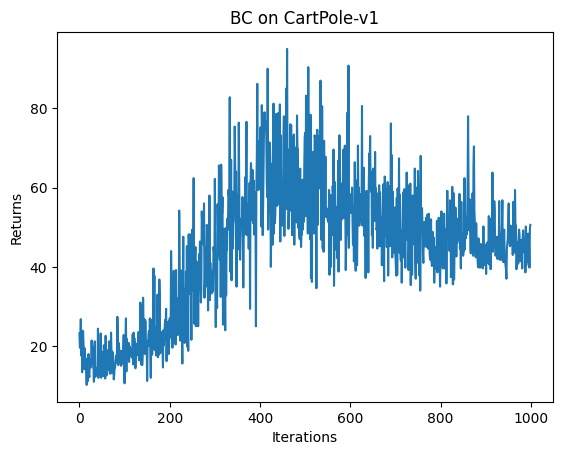

In [6]:
# Behavior Cloning 将专家数据中的中的视为标签，BC 则转化成监督学习中经典的分类问题
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions,dtype=torch.long).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = torch.mean(-log_probs)  # 最大似然估计
        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()


def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state, info = env.reset(seed=0)
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)

torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,
                                           high=expert_s.shape[0],
                                           size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()
# 我们发现 BC 无法学习到最优策略（不同设备运行结果可能会有不同），这主要是因为在数据量比较少的情况下，学习容易发生过拟合。

In [11]:
# GAIL生成式对抗模仿学习代码实践
# 实现判别器模型，其模型架构为一个两层的全连接网络，模型输入为一个状态动作对，输出一个概率标量。

class Discriminator(nn.Module):
    def __init__(self, state_dim,hidden_dim,action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(state_dim+action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        cat = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(cat))
        x = torch.sigmoid(self.fc2(x))
        return x


In [12]:
# 正式实现 GAIL 的代码。每一轮迭代中，GAIL 中的策略和环境交互，
# 采样新的状态动作对。基于专家数据和策略新采样的数据，首先训练判别器，
# 然后将判别器的输出转换为策略的奖励信号，指导策略用 PPO 算法做训练。

class GAIL:
    def __init__(self,agent,state_dim,action_dim,hidden_dim,lr_d):
        self.discriminator = Discriminator(state_dim,hidden_dim,action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(),lr=lr_d)
        self.agent = agent

    def learn(self,expert_s,expert_a,agent_s, agent_a,next_s,dones):
        expert_states = torch.tensor(expert_s,dtype=torch.float).to(device)
        expert_actions = torch.tensor(expert_a,dtype=torch.float).to(device)
        agent_states = torch.tensor(agent_s,dtype=torch.float).to(device)
        agent_actions = torch.tensor(agent_a,dtype=torch.float).to(device)
        expert_actions = F.one_hot(expert_actions.to(torch.int64),num_classes=2).float()
        agent_actions = F.one_hot(agent_actions.to(torch.int64),num_classes=2).float()

        expert_prob = self.discriminator(expert_states,expert_actions)
        agent_prob = self.discriminator(agent_states,agent_actions)
        discrminator_loss = nn.BCELoss()(
            expert_prob,torch.zeros_like(expert_prob)) + nn.BCELoss()(agent_prob,torch.ones_like(agent_prob))
        self.discriminator_optimizer.zero_grad()
        discrminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states':agent_s,
            'actions':agent_a,
            'rewards':rewards,
            'next_states':next_s,
            'dones':dones
        }
        self.agent.update(transition_dict)

torch.manual_seed(0)
lr_d = 1e-3
agent = PPO(state_dim,hidden_dim,action_dim,actor_lr,critic_lr,lmbda,epochs,eps,gamma,device)

gail = GAIL(agent,state_dim,action_dim,hidden_dim,lr_d)
n_episode = 200
return_list=[]

with tqdm(total=n_episode,desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state,info = env.reset(seed=0)
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        dones_list = []

        while not done:
            action = agent.take_action(state)
            next_state,reward,done,*_ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            dones_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s,expert_a,state_list,action_list,next_state_list,dones_list)
        if(i+1)%10==0:
            pbar.set_postfix({'return':'%.3f'%np.mean(return_list[-10:])})
        pbar.update(1)

    
        

进度条:   0%|          | 0/200 [00:00<?, ?it/s]

进度条: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s, return=591.800]


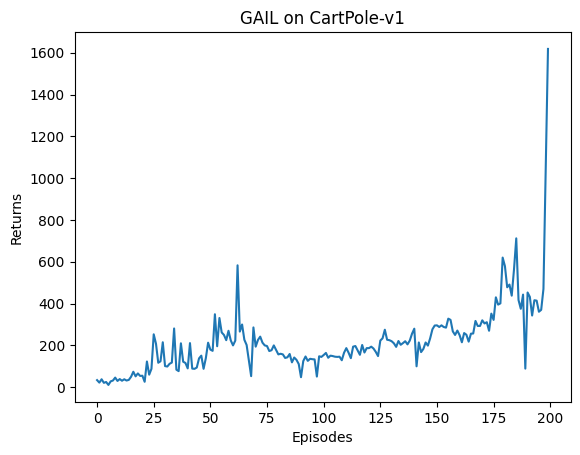

In [13]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()